# Example 11-2. Movie embedding with Movielense data

- 각 User가 movie에 대해 평가한 리뷰 데이터
- 'Sleepless in Seattle'을 좋아하는 사람은 또 어떤 다른 영화를 좋아했을까?
- 한 user가 긍정적으로 리뷰한 영화들을 하나의 문장으로 구성하여 영화 간의 관계를 고려한 embedding vector로 영화를 표현해보자

In [2]:
!pip install gensim

    100% |████████████████████████████████| 24.2MB 888kB/s ta 0:00:011
    100% |████████████████████████████████| 61kB 19.3MB/s ta 0:00:01
    100% |████████████████████████████████| 1.4MB 12.4MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 20.3MB/s ta 0:00:01
    100% |████████████████████████████████| 133kB 27.6MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 19.4MB/s ta 0:00:01
    100% |████████████████████████████████| 143kB 28.9MB/s ta 0:00:01
    100% |████████████████████████████████| 163kB 28.9MB/s ta 0:00:01
    100% |████████████████████████████████| 153kB 28.3MB/s ta 0:00:01
    100% |████████████████████████████████| 5.5MB 4.2MB/s eta 0:00:01
    100% |████████████████████████████████| 71kB 21.5MB/s ta 0:00:01
    100% |████████████████████████████████| 552kB 21.7MB/s ta 0:00:01
  Stored in directory: /home/work/.cache/pip/wheels/b8/cb/43/c0ba52baf2b0e371ec1d5b2d4685d6d24617b1391f3eeacda5
Successfully built smart-open
You are using pip ver

In [3]:
import zipfile
import pandas as pd
from gensim.models import Word2Vec
import matplotlib.pyplot as plt


### 데이터 다운로드

In [4]:
!wget http://files.grouplens.org/datasets/movielens/ml-20m.zip

--2019-06-01 05:29:06--  http://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M  2.97MB/s    in 77s     

2019-06-01 05:30:29 (2.45 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]



In [5]:
zipfile.ZipFile('ml-20m.zip').extractall(path='data/')

In [6]:
ratings = pd.read_csv('data/ml-20m/ratings.csv')
movies = pd.read_csv('data/ml-20m/movies.csv')

In [7]:
ratings.shape, movies.shape

((20000263, 4), (27278, 3))

In [8]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [9]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### 데이터 전처리

- 평점이 3보다 큰 리뷰만 남김

In [10]:
ratings = ratings.loc[ratings.rating>3]

- 영화별 리뷰 개수, 유저별 리뷰 개수 계산 

In [11]:
counts_mv = ratings.movieId.value_counts()
counts_usr = ratings.userId.value_counts()

In [12]:
len(counts_mv), len(counts_usr)

(22884, 138362)

- 총 22884개의 영화, 138362명의 유저를 포함하고 있음 
- 총 5000개 이상의 리뷰가 있는 영화, 총 500개 이상의 리뷰를 남긴 유저만 남김

In [13]:
sum(counts_mv>5000), sum(counts_usr>500)

(587, 2592)

In [14]:
ratings = ratings.loc[ratings.movieId.isin(counts_mv.loc[(counts_mv > 5000)].index)]
ratings = ratings.loc[ratings.userId.isin(counts_usr.loc[(counts_usr > 500)].index)]

In [15]:
ratings.shape

(680083, 4)

### 문장의 구성

- 영화 id와 제목을 연결하는 딕셔너리를 구성

In [16]:
id2name = dict(movies[['movieId', 'title']].values)

In [17]:
id2name

{131072: 'Jesus liebt mich (2012)',
 1: 'Toy Story (1995)',
 2: 'Jumanji (1995)',
 3: 'Grumpier Old Men (1995)',
 4: 'Waiting to Exhale (1995)',
 5: 'Father of the Bride Part II (1995)',
 6: 'Heat (1995)',
 7: 'Sabrina (1995)',
 8: 'Tom and Huck (1995)',
 9: 'Sudden Death (1995)',
 10: 'GoldenEye (1995)',
 11: 'American President, The (1995)',
 12: 'Dracula: Dead and Loving It (1995)',
 13: 'Balto (1995)',
 14: 'Nixon (1995)',
 15: 'Cutthroat Island (1995)',
 16: 'Casino (1995)',
 17: 'Sense and Sensibility (1995)',
 18: 'Four Rooms (1995)',
 19: 'Ace Ventura: When Nature Calls (1995)',
 20: 'Money Train (1995)',
 21: 'Get Shorty (1995)',
 22: 'Copycat (1995)',
 23: 'Assassins (1995)',
 24: 'Powder (1995)',
 25: 'Leaving Las Vegas (1995)',
 26: 'Othello (1995)',
 27: 'Now and Then (1995)',
 28: 'Persuasion (1995)',
 29: 'City of Lost Children, The (Cité des enfants perdus, La) (1995)',
 30: 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 31: 'Dangerous Minds (1995)',
 32: 'Twe

<font color=blue>
    
TO DO: 아래의 사항을 고려하여 코드를 완성하시오.
- 각 userId가 긍정평가한 영화제목들을 모아 하나의 문장으로 구성
- 영화제목은 timestamp를 기준으로 정렬
- 예) 
        data[0]

        ['Gone with the Wind (1939)',
         'Sleepless in Seattle (1993)',
         'Annie Hall (1977)',
         ...

        len(data) = 총 user의 수 



In [20]:
data =[]
for key, chunk in ratings.groupby('userId'):
    ids = chunk.sort_values(['timestamp']).movieId
    # Your answer comes here
    sentence =[id2name[id] for id in ids]
    data.append(sentence)


In [31]:
ratings.head()

,userId,movieId,rating,timestamp
6343,58,1,5.0,1144058408
6344,58,6,4.5,1144058615
6345,58,11,4.5,1144058674
6346,58,16,4.0,1011840790
6347,58,21,5.0,974715578


In [32]:
len(data)

2592

In [34]:
data[1]

['Saving Private Ryan (1998)',
 'Jaws (1975)',
 "Breakfast at Tiffany's (1961)",
 'American Beauty (1999)',
 'Abyss, The (1989)',
 'Cast Away (2000)',
 'Erin Brockovich (2000)',
 'Elizabeth (1998)',
 'Fight Club (1999)',
 'Gladiator (2000)',
 'Galaxy Quest (1999)',
 'Frequency (2000)',
 'Ghostbusters (a.k.a. Ghost Busters) (1984)',
 'Maltese Falcon, The (1941)',
 'Magnolia (1999)',
 'Mission: Impossible II (2000)',
 'Office Space (1999)',
 'Night of the Living Dead (1968)',
 'Patriot, The (2000)',
 'Sleepy Hollow (1999)',
 'Sixth Sense, The (1999)',
 'Shakespeare in Love (1998)',
 'Thomas Crown Affair, The (1999)',
 'Talented Mr. Ripley, The (1999)',
 'X-Men (2000)',
 'Who Framed Roger Rabbit? (1988)',
 'Dead Poets Society (1989)',
 'Leaving Las Vegas (1995)',
 'Say Anything... (1989)',
 'Labyrinth (1986)',
 'Broken Arrow (1996)',
 'Speed (1994)',
 'Piano, The (1993)',
 'True Lies (1994)',
 "Rosemary's Baby (1968)",
 'Dirty Dancing (1987)',
 'Three Musketeers, The (1993)',
 'American P

###  Word Embedding

<font color=blue>

TO DO: 위에서 만든 `data`를 사용하여 Word2Vec 알고리즘으로 word embedding 을 수행하시오.



In [23]:
EMB_SIZE=50
# Your answer comes here
model = Word2Vec(data, size=EMB_SIZE, window=5, min_count=100)
    

<font color=blue>

TO DO: Embedding matrix의 shape은 무엇인가? 



In [24]:
weight = model.wv.vectors
weight.shape

(587, 50)

<font color=blue>

TO DO: 'Sleepless in Seattle (1993)'과 가장 가까운 거리를 가지는 영화들은 무엇인가?



In [25]:
model.wv.most_similar('Sleepless in Seattle (1993)')

[('Ghost (1990)', 0.9219340085983276),
 ('Pretty Woman (1990)', 0.9012452960014343),
 ('While You Were Sleeping (1995)', 0.874081552028656),
 ('Four Weddings and a Funeral (1994)', 0.8607441782951355),
 ('Mrs. Doubtfire (1993)', 0.8422134518623352),
 ('Birdcage, The (1996)', 0.8249579071998596),
 ('Mask, The (1994)', 0.822340190410614),
 ('Clueless (1995)', 0.7669179439544678),
 ('Titanic (1997)', 0.7440730333328247),
 ('Firm, The (1993)', 0.7207993865013123)]

## Embedding 결과의 시각화

<font color=blue>

TO DO: TSNE를 사용하여 embedding matrix를 2차원으로 축약하고 가장 리뷰가 많은 50개 영화에 대해 2차원 평면에서 표현하시오. 



In [28]:
from sklearn.manifold import TSNE
tsne = TSNE()
transformed = tsne.fit_transform(weight)

In [18]:
N_TOPS = 50
topmovies = [id2name.get(key) for key in counts_mv[:N_TOPS].index]

In [19]:
topmovies

['Shawshank Redemption, The (1994)',
 'Pulp Fiction (1994)',
 'Silence of the Lambs, The (1991)',
 'Forrest Gump (1994)',
 'Star Wars: Episode IV - A New Hope (1977)',
 "Schindler's List (1993)",
 'Matrix, The (1999)',
 'Braveheart (1995)',
 'Usual Suspects, The (1995)',
 'Terminator 2: Judgment Day (1991)',
 'Fugitive, The (1993)',
 'American Beauty (1999)',
 'Star Wars: Episode V - The Empire Strikes Back (1980)',
 'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)',
 'Jurassic Park (1993)',
 'Toy Story (1995)',
 'Godfather, The (1972)',
 'Star Wars: Episode VI - Return of the Jedi (1983)',
 'Fargo (1996)',
 'Fight Club (1999)',
 'Seven (a.k.a. Se7en) (1995)',
 'Apollo 13 (1995)',
 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)',
 'Sixth Sense, The (1999)',
 'Back to the Future (1985)',
 'Lord of the Rings: The Fellowship of the Ring, The (2001)',
 'Saving Private Ryan (1998)',
 'Lord of the Rings: The Two Towers, The (2002)',
 'Dances with Wolves (1990)',
 '

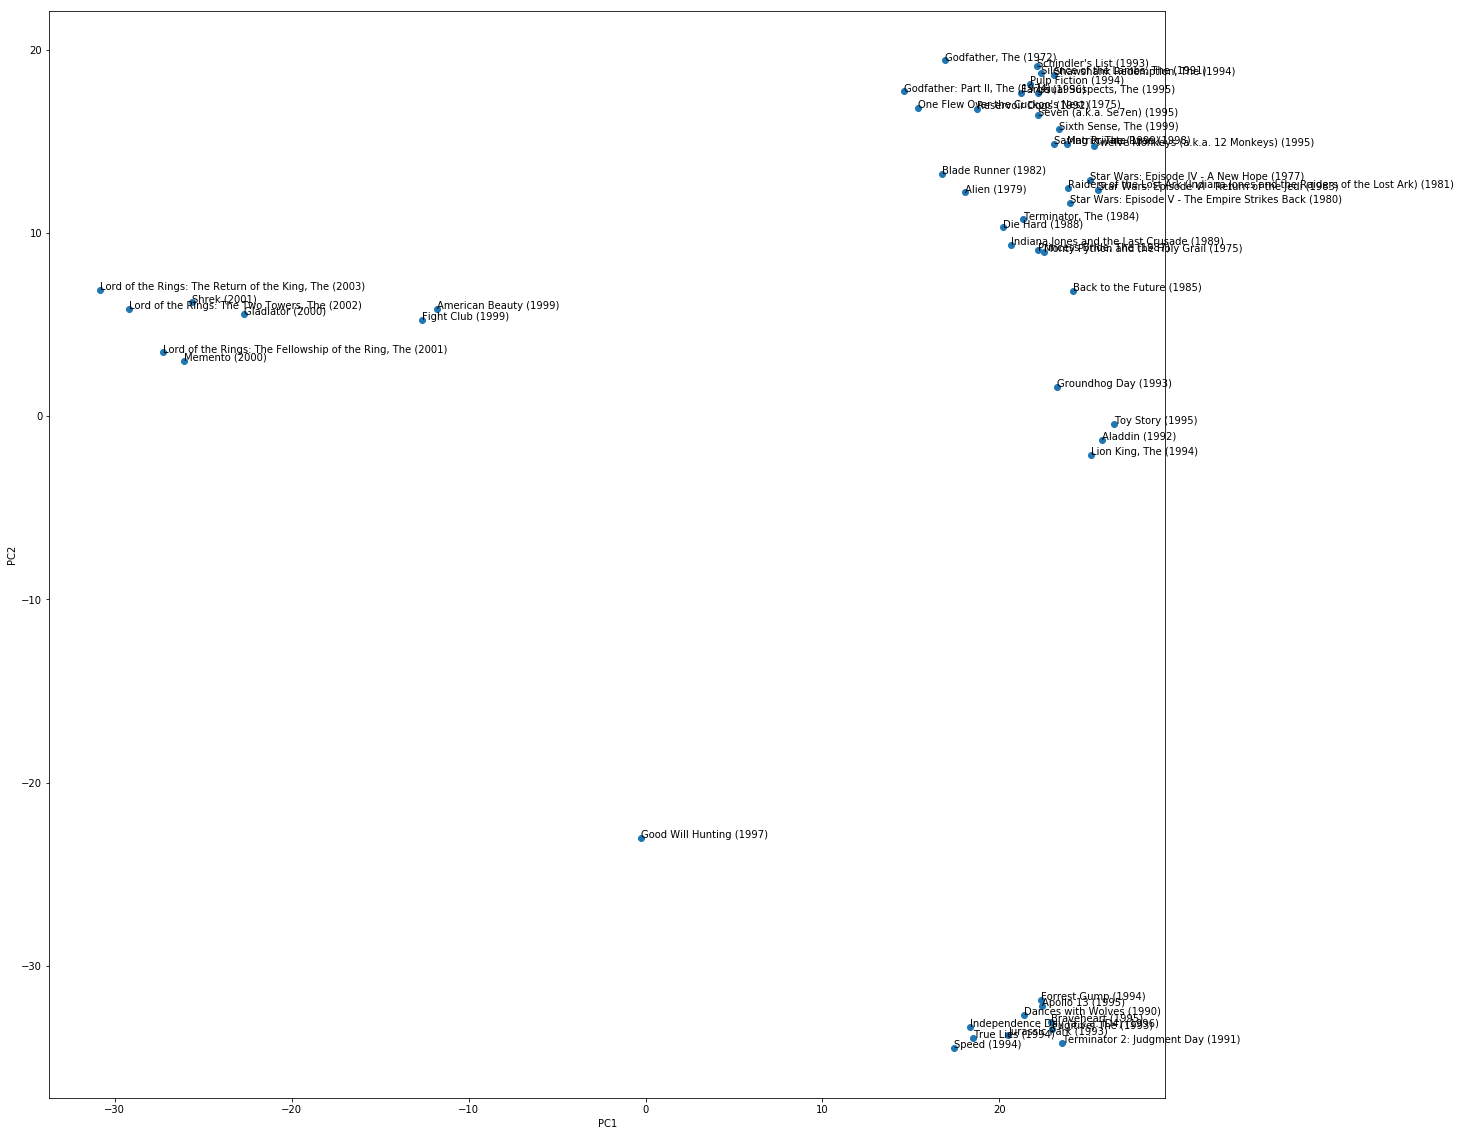

In [29]:
word2idx = dict((w,i) for (i, w) in enumerate(model.wv.index2word))
idx = [word2idx.get(key) for key in topmovies]

xs = transformed[idx, 0]
ys = transformed[idx, 1]

fig = plt.figure(figsize=(20,20))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.scatter(xs, ys)

for i, word in enumerate(topmovies):
    plt.annotate(word, xy=(xs[i], ys[i]))
plt.show()